# Ingest Flood Extent Maps

* **Last Modified**: 07-04-2021
* **Authors**: Nadia Ahmed, Gonzalo Mateo-García
---

> Acquire flood metadata and floodmaps from Copernicus Emergency Management Service and retrieve co-located Sentinel-2 images and permanent water masks from the Google Earth Engine.

## Overview
In this notebook we will:
 1. Examine a specific flood event
 2. Build Flood MetaData and Floodmap using
     - area of interest (AOI)
     - observed flood event
     - hydrography areas
     - hydrography lines
 3. Retrieve Sentinel-2 and JRC Permanent Water for a Flood AOI

## 1 - Flood Events

<!-- 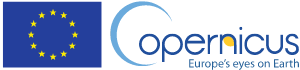 -->

![europecopernicus.png](./images/copernicus_ems_europe_flag.png)

Copernicus Emergency Management Service (EMS) provides warnings and risk assessment of floods and other natural disasters through geospatial data derived from satellite imagery. It provides data before, during, and after events in Rapid Mapping format for emergencies and Risk and Recovery format for prevention. In WorldFloods we are primarily interested in the satellite derived imagery with a focus on fluvial, or river, floods.

### Copernicus EMS Rapid Activations

The Copernicus EMS Activation Mappings for individual events given by unique EMSR codes may be accessed [here](https://emergency.copernicus.eu/mapping/list-of-activations-rapid). Linked to each EMSR code per severe event in the Rapid Activations table is the individual webpage for the EMSR code featuring vector zip files from various sources. Each vector zip file may contain multiple products with respect to an event. For this notebook, we will walk through a single EMSR flood event from the alert code, to its associated url.

We may retrieve a pandas DataFrame format of the [EMS Rapid Activations](https://emergency.copernicus.eu/mapping/list-of-activations-rapid) table using the function <code>table_floods_ems</code> from the activations module in `ml4floods/data`. In this function you may specify how far back in time you would like to retrieve flood emergency mappings for. Be careful when choosing dates _prior to 23 June 2015_ when Sentinel-2 was launched into space.

In [1]:
# Install the ml4floods package
!pip install geemap
!pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods

  Cloning https://github.com/spaceml-org/ml4floods to /tmp/pip-install-ccd3jpat/ml4floods_8eb3a646692647a49e9ba6678b10471c
  Running command git clone --filter=blob:none --quiet https://github.com/spaceml-org/ml4floods /tmp/pip-install-ccd3jpat/ml4floods_8eb3a646692647a49e9ba6678b10471c
^C
ERROR: Operation cancelled by user


In [2]:
import sys
import os

from ml4floods.data.copernicusEMS import activations
from ml4floods.data import utils
from pathlib import Path

Let's take a look at the flood events that have occurred since the start of 2021.

In [4]:
table_activations_ems = activations.table_floods_ems(event_start_date="2021-01-01")
table_activations_ems

Title    CodeDate   Type  \
Code                                                                    
EMSR568                Cyclone Gombe in Mozambique  2022-03-11  Flood   
EMSR567            Floods in Queensland, Australia  2022-02-26  Flood   
EMSR565      Tropical Cyclone Emnati in Madagascar  2022-02-22  Storm   
EMSR564    Tropical Cyclone Batsirai in Madagascar  2022-02-05  Storm   
EMSR563       Tropical Cyclone BATSIRAI in Réunion  2022-02-02  Storm   
EMSR562                        Floods in Australia  2022-01-29  Flood   
EMSR561                           Floods in Malawi  2022-01-24  Flood   
EMSR559                        Flood in Madagascar  2022-01-18  Flood   
EMSR557                           Floods in Norway  2022-01-13  Flood   
EMSR556             Super Typhoon Rai, Philippines  2021-12-13  Storm   
EMSR555       Flood in the Ebro river basin, Spain  2021-12-10  Flood   
EMSR554            Floods in Queensland, Australia  2021-12-01  Flood   
EMSR552                        Windstorm in Norway  2021-11-19  Storm   
EMSR551       Flood in Sulaymaniyah District, Iraq  2021-11-20  Flood   
EMSR550        Flood in New South Wales, Australia  2021-11-10  Flood   
EMSR548             Flood in Eastern Sicily, Italy  2021-10-24  Flood   
EMSR520                       Flood in Netherlands  2021-07-16  Flood   
EMSR519                       Flood in Switzerland  2021-07-15  Flood   
EMSR518                           Flood in Belgium  2021-07-14  Flood   
EMSR517                   Flood in Western Germany  2021-07-13  Flood   
EMSR514                            Flood in Guyana  2021-06-07  Flood   
EMSR511                  Flood in Lapland, Finland  2021-05-20  Flood   
EMSR507                       Flood in Timor-Leste  2021-04-04  Flood   
EMSR504                          Floods, Australia  2021-03-19  Flood   
EMSR502                  Flood in Southern Ireland  2021-02-23  Flood   
EMSR501                           Flood in Albania  2021-01-06  Flood   
EMSR498        Flood in Corrèze department, France  2021-02-02  Flood   
EMSR497                           Flood in Germany  2021-02-01  Flood   
EMSR496               Flood in Lazio Region, Italy  2021-01-26  Flood   
EMSR495  Tropical cyclone Eloise in Mozambique,...  2021-01-22  Storm   
EMSR492                    Flood in Landes, France  2021-01-01  Flood   

                                Country  
Code                                     
EMSR568                      Mozambique  
EMSR567                       Australia  
EMSR565                      Madagascar  
EMSR564                      Madagascar  
EMSR563                         Reunion  
EMSR562                       Australia  
EMSR561                          Malawi  
EMSR559                      Madagascar  
EMSR557                          Norway  
EMSR556                     Philippines  
EMSR555                           Spain  
EMSR554                       Australia  
EMSR552                          Norway  
EMSR551                            Iraq  
EMSR550                       Australia  
EMSR548                           Italy  
EMSR520                     Netherlands  
EMSR519                     Switzerland  
EMSR518            Belgium, Netherlands  
EMSR517                         Germany  
EMSR514                          Guyana  
EMSR511                         Finland  
EMSR507                     Timor-Leste  
EMSR504                       Australia  
EMSR502                         Ireland  
EMSR501                         Albania  
EMSR498                          France  
EMSR497                         Germany  
EMSR496                           Italy  
EMSR495  Mozambique, Eswatini, Zimbabwe  
EMSR492                          France

### EMSR 501: Flood in Shkodra, Albania
During heavy rains 4000 hectares of land was affected by flooding impacting 200 people. We take this event as an example to show how we retrieve and ingest data as an entry point to the preprocessed data used in the WorldFloods machine learning pipeline.

<!-- 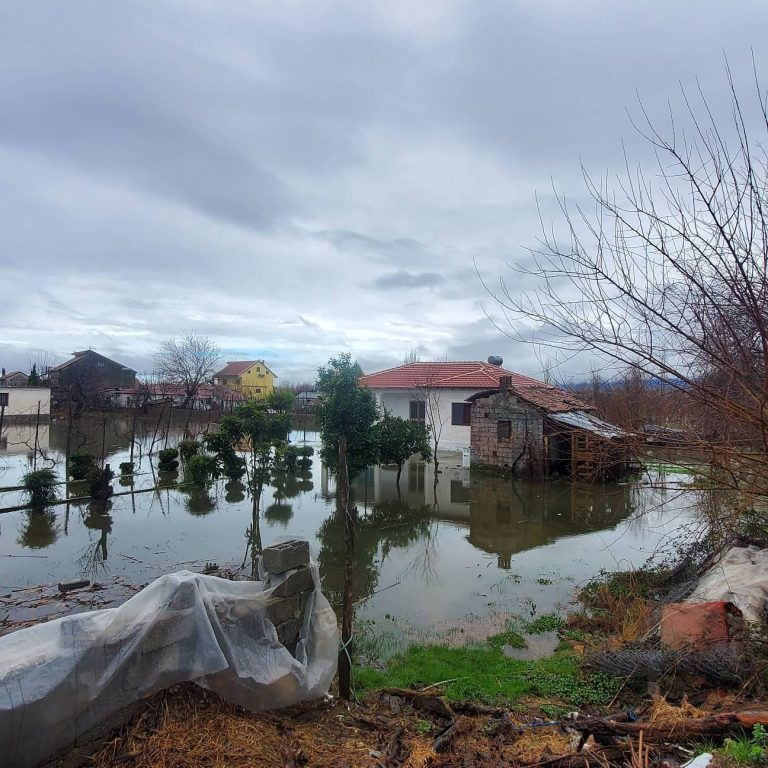 -->
![albania_picture.png](./images/albania_picture.png)

#### Retrieve the Zip File URLs for a given EMSR Code

The Copernicus EMS Activation Mapping URL location for the January 6th flood event in Shkodra, Albania can be fetched using the activation code "EMSR501" and the function <code>fetch_zip_files</code> from <code>activation.py</code> which outputs the url locations as a list of strings. Each of these zip file urls allow us to retrieve the vector shapefiles for different areas of interest within a single activation code.

In [5]:
emsr_code = "EMSR501"
zip_files_activation_url_list = activations.fetch_zip_file_urls(emsr_code)
zip_files_activation_url_list

['https://emergency.copernicus.eu/mapping/download/184632/EMSR501_AOI01_DEL_MONIT02_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/184615/EMSR501_AOI01_DEL_MONIT01_r1_VECTORS_v1_vector.zip',
 'https://emergency.copernicus.eu/mapping/download/184606/EMSR501_AOI01_DEL_PRODUCT_r1_VECTORS_v1_vector.zip']

Notice that this particular EMSR flood code has several area of interest (AOI) files. These files are present in the ml4cc_data_lake Google Cloud Storage bucket repository in their unzipped raw format as well as their zipped format. They can be found in the following locations:

- zipped files: gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_zip
- unzipped files: gs://ml4cc_data_lake/0_DEV/0_Raw/WorldFloods/copernicus_ems/copernicus_ems_unzip

#### Saving the Zip Files and Unzipping Locally

If you would like to save the zip files locally, you may do so by downloading them directly from _ml4cc_data_lake_ or by downloading the zip files directly from the Copernicus EMS rapid activations. Since this notebook goes over data ingestion from start to finish, we explain the process for both cases. To save the files locally we do the following: 

In [6]:
from tqdm import tqdm
import os
folder_out = f"Copernicus_EMS_raw"
os.makedirs(folder_out, exist_ok=True)

unzip_files_activation = []
for zip_file in tqdm(zip_files_activation_url_list):
    local_zip_file = activations.download_vector_cems(zip_file, 
                                                      folder_out=folder_out)
    unzipped_file = activations.unzip_copernicus_ems(local_zip_file,
                                                     folder_out=folder_out)
    unzip_files_activation.append(unzipped_file)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 332.11it/s]

	File https://emergency.copernicus.eu/mapping/download/184632/EMSR501_AOI01_DEL_MONIT02_r1_VECTORS_v1_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/184615/EMSR501_AOI01_DEL_MONIT01_r1_VECTORS_v1_vector.zip already exists. Not downloaded
	File https://emergency.copernicus.eu/mapping/download/184606/EMSR501_AOI01_DEL_PRODUCT_r1_VECTORS_v1_vector.zip already exists. Not downloaded


## 2 - Building EMSR Flood Metadata and Floodmaps

Following the scraping and downloading of Copernicus EMS Rapid Mapping Products in, we unzipped the files in our local file directory or to the Google Cloud Storage Bucket.

Once unzipped, multiple `.shp` files can be associated with a single EMSR Flood Activation Code. These files represent different activation layer data available as Copernicus EMS rapid mapping products. For more details with respect to each of the layers see below.

<!-- 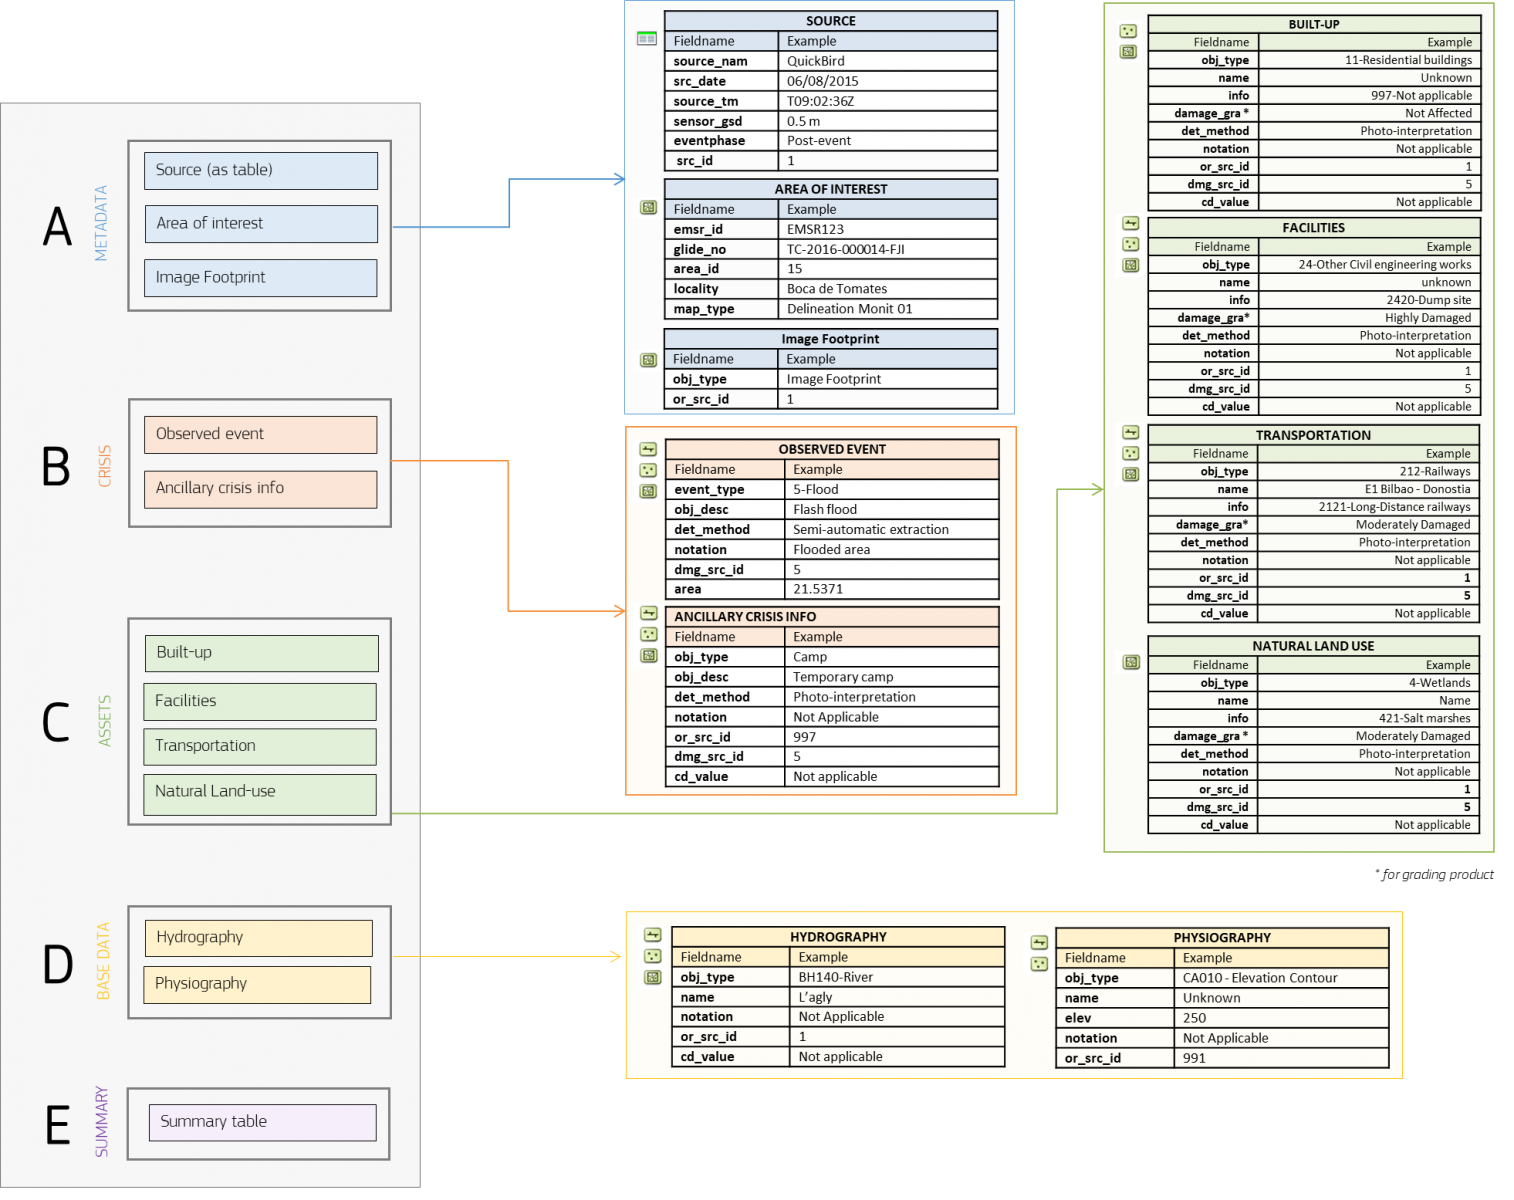 -->

![diagram_copernicus.png](images/diagram_copernicus.png)

The layers of particular value to WorldFloods are the Metadata (A), Crisis (B), and Base Data (D) layers. More specifically, we are interested retrieving:

- A: Source and The Area of Interest (AOI)
- B: Observed Event data for Floods
- D: Hydrography areas and lines indicative of lakes and rivers 

With these data we can create a composite floodmask over an AOI. We will later obtain Sentinel-2 images associated with an AOI which we will overlay with a floodmap layer derived from A, B, and D Copernicus EMS products.

These shapefiles will be used to compose a floodmap for use in the generation of ground truth labels to be used in a supervised learning model pipeline.

### 2a - Process Shapefiles 

In function `filter_register_copernicusems` we check that all the `.shp` follow the expected conventions with respect to timestamp and data availability.

### 2b - Populate Copernicus EMSR Metadata Dictionary
`filter_register_copernicusems` upon extracting the source, AOI, observed event, and hydrography information, will populate a dictionary with keys associated with the source data and hold the filenames and paths of specific `.shp` files as values. 

### 2c - Generate Floodmap

We then process the `.shp` files area of interest, observed event, and the hydrography into a single `geopandas.GeoDataFrame` object using `generate_floodmap`. This information will be uploaded to the WorldFloods data bucket for new events.


In [7]:
# folder_out=f"Copernicus_EMS_raw/{activation}"

code_date = table_activations_ems.loc[emsr_code]["CodeDate"]

registers = []
for unzip_folder in unzip_files_activation:
    metadata_floodmap = activations.filter_register_copernicusems(unzip_folder, code_date)
    if metadata_floodmap is not None:
        floodmap = activations.generate_floodmap(metadata_floodmap, folder_files=unzip_folder)
        registers.append({"metadata_floodmap": metadata_floodmap, "floodmap": floodmap})
        print(f"File {unzip_folder} processed correctly")
    else:
        print(f"File {unzip_folder} does not follow the expected format. It won't be processed")


/home/gonzalo/git/ml4floods/ml4floods/data/utils.py:39: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  land_geometries = cascaded_union(land_geometries.tolist())


File Copernicus_EMS_raw/EMSR501_AOI01_DEL_MONIT02_r1_VECTORS_v1_vector processed correctly


/home/gonzalo/git/ml4floods/ml4floods/data/utils.py:39: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  land_geometries = cascaded_union(land_geometries.tolist())


File Copernicus_EMS_raw/EMSR501_AOI01_DEL_MONIT01_r1_VECTORS_v1_vector processed correctly
File Copernicus_EMS_raw/EMSR501_AOI01_DEL_PRODUCT_r1_VECTORS_v1_vector processed correctly


/home/gonzalo/git/ml4floods/ml4floods/data/utils.py:39: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  land_geometries = cascaded_union(land_geometries.tolist())


In [8]:
floodmap.head()

geometry       w_class source
0  POLYGON ((19.49257 42.09545, 19.49258 42.09541...  Flooded area  flood
1  POLYGON ((19.51681 42.09338, 19.51681 42.09329...  Flooded area  flood
2  POLYGON ((19.50074 42.09272, 19.50074 42.09263...  Flooded area  flood
3  POLYGON ((19.50933 42.09266, 19.50933 42.09257...  Flooded area  flood
4  POLYGON ((19.50763 42.09290, 19.50763 42.09281...  Flooded area  flood

In [9]:
import numpy as np
np.unique(floodmap.source)

array(['area_of_interest', 'flood', 'hydro', 'hydro_l'], dtype=object)

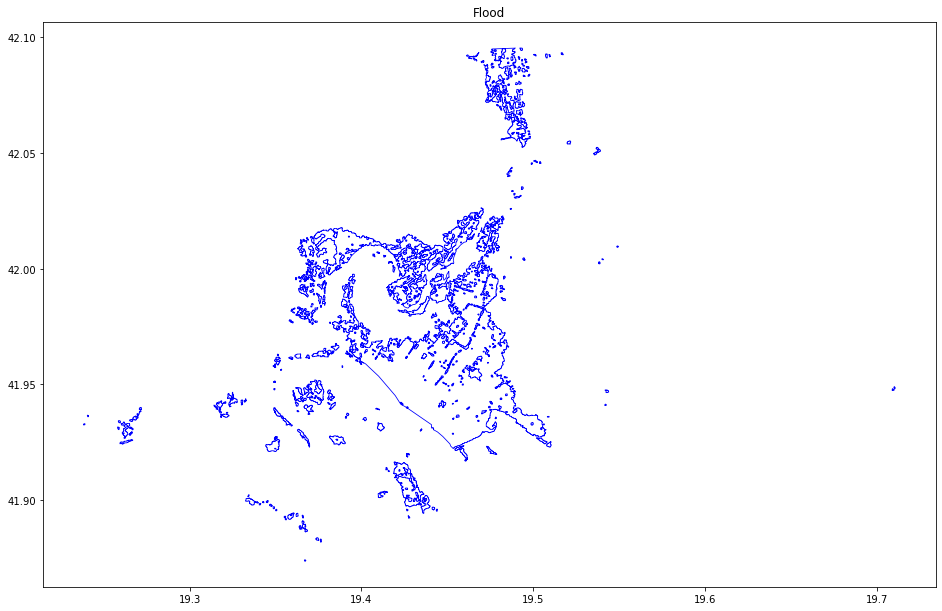

In [10]:
import matplotlib.pyplot as plt
# initialize figure
fig, ax = plt.subplots(figsize=(16,16))
floodmap[floodmap["source"] == "flood"].plot(ax=ax, facecolor="None", edgecolor="blue", label="Flood Maps", linewidth=0.8)
ax.set(
    title="Flood"
)
plt.show()

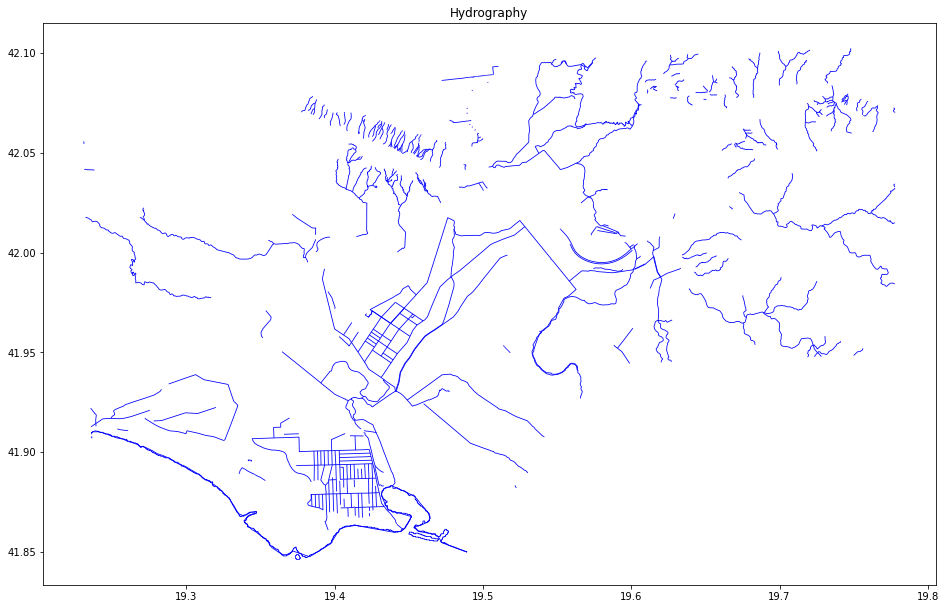

In [11]:
import matplotlib.pyplot as plt
# initialize figure
fig, ax = plt.subplots(figsize=(16,16))
floodmap[floodmap["source"] == "hydro_l"].plot(ax=ax, facecolor="None", edgecolor="blue", label="Flood Maps", linewidth=0.8)
ax.set(
    title="Hydrography"
)
plt.show()

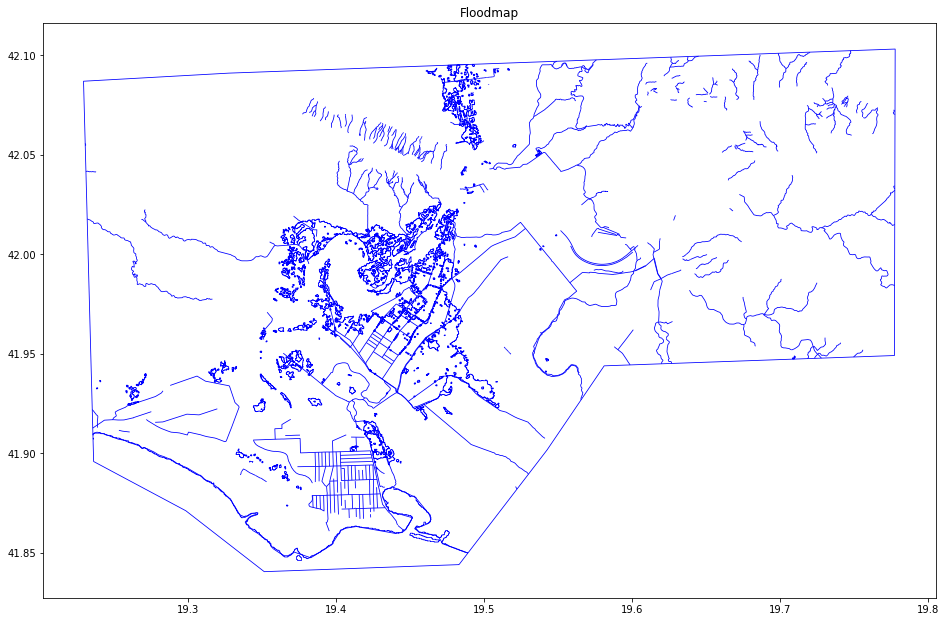

In [12]:
import matplotlib.pyplot as plt
# initialize figure
fig, ax = plt.subplots(figsize=(16,16))
floodmap[floodmap["source"] != "hydro"].plot(ax=ax, facecolor="None", edgecolor="blue", label="Flood Maps", linewidth=0.8)
ax.set(
    title="Floodmap"
)
plt.show()

In [13]:
metadata_floodmap

{'event id': 'EMSR501_AOI01_DEL_PRODUCT',
 'layer name': 'EMSR501_AOI01_DEL_PRODUCT_observedEventA_r1_v1',
 'event type': 'Flash flood',
 'satellite date': Timestamp('2021-02-12 16:32:21+0000', tz='UTC'),
 'country': 'NaN',
 'satellite': 'Sentinel-1',
 'bounding box': {'west': 19.238301964000073,
  'east': 19.710555657000043,
  'north': 42.095451798000056,
  'south': 41.873487114000056},
 'reference system': 'epsg:4326',
 'abstract': 'NaN',
 'purpose': 'NaN',
 'source': 'CopernicusEMS',
 'area_of_interest_polygon': <shapely.geometry.polygon.Polygon at 0x7f56811326d0>,
 'observed_event_file': 'EMSR501_AOI01_DEL_PRODUCT_observedEventA_r1_v1.shp',
 'area_of_interest_file': 'EMSR501_AOI01_DEL_PRODUCT_areaOfInterestA_r1_v1.shp',
 'ems_code': 'EMSR501',
 'aoi_code': 'AOI01',
 'date_ems_code': datetime.datetime(2021, 1, 6, 0, 0, tzinfo=datetime.timezone.utc),
 'satellite_pre_event': 'Open Street Map',
 'timestamp_pre_event': Timestamp('2021-02-12 00:00:00+0000', tz='UTC'),
 'hydrology_file': 

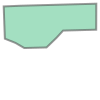

In [14]:
metadata_floodmap["area_of_interest_polygon"]

## 3 - Sentinel-2 and JRC Permanent Water Imagery Using Google Earth Engine

### Sentinel-2 Image Retrieval Using Google Earth Engine

To retrieve Sentinel-2 images from Google Earth Engine, make sure you create an account and authenticate prior to running the cell below. The link to sign up is [here](https://earthengine.google.com/new_signup/).



<!-- 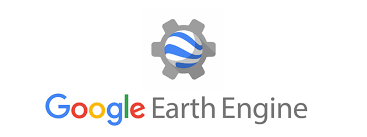 -->
![google_earth_engine_picture.png](images/google_earth_engine_picture.png)

To query and download the Sentinel-2 images we will use the module <code>ee_download</code> and interact with the map using <code>geemap.eefolium</code>.

We use the AOI polygons retrieved from CopernicusEMS to select the location and time that we are interested in and use Google Earth Engine to do the georeferencing. Notice that we may also render the hydrography and observed flood event.

In [15]:
from datetime import timedelta
from datetime import datetime
import geopandas as gpd
import pandas as pd
import ee
import geemap.eefolium as geemap
import folium
from ml4floods.data import ee_download, create_gt
from shapely.geometry import mapping

In [ ]:
!earthengine authenticate

In [21]:
ee.Initialize()

bounds_pol = activations.generate_polygon(metadata_floodmap["area_of_interest_polygon"].bounds)
pol_2_clip = ee.Geometry.Polygon(bounds_pol)

pol = ee.Geometry(mapping(metadata_floodmap["area_of_interest_polygon"]))

date_event = datetime.utcfromtimestamp(metadata_floodmap["satellite date"].timestamp())

date_end_search = date_event + timedelta(days=20)

# Grab the S2 images and the Permanent water image
img_col = ee_download.get_s2_collection(date_event, date_end_search, pol)
permanent_water_img = ee_download.permanent_water_image(date_event.year, pol_2_clip)


# Get info of the Image Collection (convert to table)
img_col_info = ee_download.img_collection_to_feature_collection(img_col,
                                                               ["system:time_start", "valids", "cloud_probability"])
img_col_info_local = gpd.GeoDataFrame.from_features(img_col_info.getInfo())
img_col_info_local["system:time_start"] = img_col_info_local["system:time_start"].apply(lambda x: datetime.utcfromtimestamp(x/1000))

n_images_col = img_col_info_local.shape[0]
print(f"Found {n_images_col} S2 images between {date_event.isoformat()} and {date_end_search.isoformat()}")

# Plot images using geemap
Map = geemap.Map()

imgs_list = img_col.toList(n_images_col, 0)
for i in range(n_images_col):
    img_show = ee.Image(imgs_list.get(i))
    Map.addLayer(img_show.clip(pol), 
                 {"min":0, "max":3000, 
                  "bands":["B4","B3","B2"]},
                 f"({i}/{n_images_col}) S2 RGB {img_col_info_local['system:time_start'][i].strftime('%Y-%m-%d')}", 
                 False)
    Map.addLayer(img_show.clip(pol), 
                 {"min":0, "max":3000, 
                  "bands":["B11","B8","B4"]},
                 f"({i}/{n_images_col}) S2 SWIR/NIR/RED {img_col_info_local['system:time_start'][i].strftime('%Y-%m-%d')}", 
                 True)

# Viz permanent water layer
visualization = {
  "bands": ['waterClass'],
  "min": 0.0,
  "max": 3.0,
  "palette": ['cccccc', 'ffffff', '99d9ea', '0000ff']
}

Map.addLayer(permanent_water_img, visualization, name="JRC Permanent water")


floodmap_folium = folium.features.GeoJson(floodmap, name="FloodMap")
Map.add_child(floodmap_folium,name="FloodMap")

# Map.addLayer(pol, {"color": 'FF000000'}, "AoI")

Map.centerObject(pol, zoom=10)
folium.LayerControl(collapsed=False).add_to(Map)
Map

Found 8 S2 images between 2021-02-12T16:32:21 and 2021-03-04T16:32:21


## Show the metadata of the Sentinel-2 files

In the previous cell we show how query images from the GEE and show them with geemap. In that code we query the metadata of the Sentinel-2 files which is a `DataFrame` object. The metadata includes the mean cloud coverage of the images.

In [24]:
img_col_info_local

geometry  cloud_probability  \
0  POLYGON ((-180.00000 -90.00000, 180.00000 -90....         100.000000   
1  POLYGON ((-180.00000 -90.00000, 180.00000 -90....          15.191459   
2  POLYGON ((-180.00000 -90.00000, 180.00000 -90....           8.315460   
3  POLYGON ((-180.00000 -90.00000, 180.00000 -90....          94.017820   
4  POLYGON ((-180.00000 -90.00000, 180.00000 -90....           4.401171   
5  POLYGON ((-180.00000 -90.00000, 180.00000 -90....           7.978288   
6  POLYGON ((-180.00000 -90.00000, 180.00000 -90....           4.595103   
7  POLYGON ((-180.00000 -90.00000, 180.00000 -90....           8.042142   

        system:time_start  valids  
0 2021-02-13 09:48:54.985       1  
1 2021-02-15 09:38:58.363       1  
2 2021-02-18 09:48:53.845       1  
3 2021-02-20 09:38:59.706       1  
4 2021-02-23 09:48:55.862       1  
5 2021-02-25 09:38:58.740       1  
6 2021-02-28 09:48:55.012       1  
7 2021-03-02 09:39:00.135       1

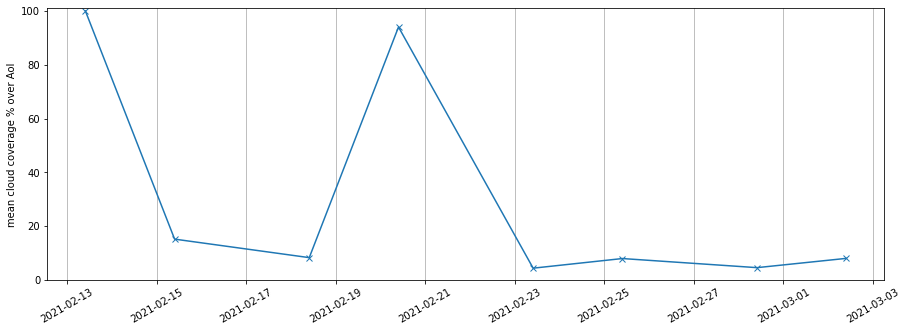

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(img_col_info_local["system:time_start"], img_col_info_local["cloud_probability"],marker="x")
plt.ylim(0,101)
plt.xticks(rotation=30)
plt.ylabel("mean cloud coverage % over AoI")
plt.grid(axis="x")

#### Export one of the images to Google Drive

In [ ]:
BANDS_EXPORT = ["B1","B2","B3","B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12", "QA60", "probability"]

# Download SECOND! image (index 1)
i = 1
date_i = img_col_info_local['system:time_start'][i]
img_export = ee.Image(imgs_list.get(i))

print(f"Download image from date {date_i}")
img_export = img_export.select(BANDS_EXPORT).toFloat().clip(pol)

# Name of the file in your Google Drive
filename_noext = "ml4floods_flood_albania"

# use  ee.batch.Export.image.toStorage to export it to a gcp bucket
task = ee.batch.Export.image.toDrive(img_export,
                                     fileNamePrefix=filename_noext,
                                     description=filename_noext,
                                     crs='EPSG:4326',
                                     skipEmptyTiles=True,
                                     # bucket="ml4floods",
                                     scale=10,
                                     formatOptions={"cloudOptimized": True},
                                     fileDimensions=12544,
                                     maxPixels=5e9)
task.start()

The method `status()` of the `task` instance gets you the status of the exporting task. Once the state is `FINISHED` you will see the TIF file in your Google Drive folder. 

Google Earth Engine tasks can be also monitored with the [task manager](https://code.earthengine.google.com/tasks).

In [28]:
task.status()

{'state': 'RUNNING',
 'description': 'ml4floods_flood_albania',
 'creation_timestamp_ms': 1617123790366,
 'update_timestamp_ms': 1617123855192,
 'start_timestamp_ms': 1617123840398,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'PHODTJSJBMOPVZVJL7S5HS6E',
 'name': 'projects/earthengine-legacy/operations/PHODTJSJBMOPVZVJL7S5HS6E'}

## Read image from Google Drive

**Warning**: This part is only available in Google Colab; to download the file to your local computer you can use the `gdown` package.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

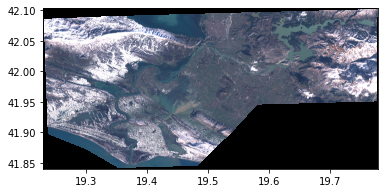

<AxesSubplot:>

In [4]:
from ml4floods.visualization import plot_utils

plot_utils.plot_rgb_image("/content/drive/My Drive/ml4floods_flood_albania.tif", size_read=600)